## Assignment 2
Abdulkadir Çelikkanat
  
_Since the equations not rendered properly on some browsers, similar [report](https://github.com/abdcelikkanat/Cmpe548-Assignment2/blob/master/report.pdf) in pdf format also added._

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

__Problem 1 (Importance Sampling)__

Let R be $\{(x,y):|x|+|y| \leq 1\}$ which is rotated square as in the previous assignment, and $\Omega = \{(x,y):|x|^p + |y|^p \leq 1\}$ for p=0.5 , and say that area of the region $\Omega$ is $c$. Then, define the function $f(x) = c\mathbb{1}_{\Omega}$. Therefore, the expectation of f(x) 
$$
\mathbb{E}_{p}[f(x)] = \int_{R}f(x)dp = \int_{\Omega}c\mathbb{1}_{\Omega}dp = cp(\Omega) = c
$$
gives the area of $\Omega$, where p is the uniform probability measure function on $\Omega$.
After changing the probabiliy measure in the equation, it can be rewritten as
$$
\mathbb{E}_{p}[f(x)] = \int_{\Omega}f(x)dp = \int_{R}f(x)\frac{p(x)}{q(x)}dq = \int_{R}f(x)w(x)dq = \mathbb{E}_{q}[f(x)w(x)]
$$
q(x) is uniform probability measure on R. Then, by Monte Carlo estimation, it can be obtained that

$$
c =\mathbb{E}_{p}[f(x)] = \frac{1}{N}\sum_{i=1}^{N}f(x^{(i)})w(x^{(i)}) = \frac{1}{N}\sum_{i=1}^{N}c\mathbb{1}_{\Omega}(x^{(i)})\frac{\frac{1}{c}}{\frac{1}{2}} =  \frac{2}{N}\sum_{i=1}^{N}\mathbb{1}_{\Omega}(x^{(i)})
$$
where $x^{(i)}$ $\sim$ q(x). The last equation indeed equals to rejection sampling.

Firstly, the function to uniformly sample points from the region __R__ is implemented below.

In [2]:
def sampleFromRotatedSquare(N):
    # Definiton of rotation matrix in counter clockwise direction
    R = np.array([[np.sqrt(2.0)/2, -np.sqrt(2.0)/2], [np.sqrt(2.0)/2, np.sqrt(2.0)/2]])
    
    # Draw random points from the square [-2^(0.5)/2, 2^(0.5)/2]^2
    x = np.random.uniform(-np.sqrt(2.0)/2, np.sqrt(2.0)/2, N)
    y = np.random.uniform(-np.sqrt(2.0)/2, np.sqrt(2.0)/2, N)
    
    # Rotate points
    [rx, ry] = R.dot([x, y])
    
    return np.vstack((rx, ry))

Now the area of the region $\Omega$ can be found as described above.

In [4]:
N = 1000 #number of samples
samples = sampleFromRotatedSquare(N)

p = 0.5
# Get the samples inside
inx = LA.norm(samples, ord=p, axis=0) < 1

c = (2.0/N) * (np.sum(inx))
print "The estimated area : " + str(c)

The estimated area : 0.642


...which is close to the real value $\frac{2}{3} = 0.\tilde{6}$

Since the variance of f(x)w(x) equals to
$$ Var_{q}(f(x)w(x)) = Var_{q}(f(x)\frac{p(x)}{q(x)}) =  Var_{q}(c\mathbb{1}_{\Omega}\frac{1/c}{1/2}) = 4 Var_{q}(\mathbb{1}_{\Omega}) $$

In [5]:
var = 4.0*np.var(samples[:,inx],axis=1)
print "Variance : " + str(var)

Variance : [ 0.33188025  0.25250144]


#### Problem 2 

__a) Construction of the transition kernel__

In [6]:
A = np.array([[0.25, 0, 0, 0, 0, 0.25],
             [0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
             [0.25, 0.25, 0, 0.5, 0.25, 0.25],
             [0, 0, 0.5, 0, 0, 0],
             [0, 0.25, 0, 0, 0.25, 0],
             [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]])
print A

[[ 0.25  0.    0.    0.    0.    0.25]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.    0.5   0.25  0.25]
 [ 0.    0.    0.5   0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.25  0.  ]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]]


__b) Stationary distribution__  

Since $A^3 > 0$, the transition matrix A is regular, so ergodic. 

In [7]:
(D, Q) = np.linalg.eig(A)
# Get the first eigenvector which corresponds to eigenvalue 1
u = Q[:,0]
# Normalize eigenvector
u = u / np.sum(u)
print "Eigenvalues : " + str(np.around(D,decimals=4))
print "Stationary distribution"
print u

Eigenvalues : [ 1.    0.25  0.   -0.5   0.25  0.  ]
Stationary distribution
[ 0.08333333  0.25        0.22222222  0.11111111  0.08333333  0.25      ]


..., so the stationary distribution is not uniform.

__c) Detailed balance equation__

To satisfy the detailed balance equation, the matrix obtained by elementwise multiplication of A with eigenvector 'u' should be symmetric 

In [8]:
# Multiply elementwise the kernel 'A' and eigenvector 'u'
S = np.multiply(A,u)
# Check whether 'S' is symmetric or not
print np.allclose(S.T, S)

False


Hence, it does not satify the detailed balance equation.

__d) The mixing time__

In [9]:
epsilon = (1e-8)

Tmix = 1
p = [1, 0, 0, 0, 0, 0] #Initial position
s = np.dot(A,p)
while (0.5*LA.norm(s-u, ord=1) > epsilon):
    s = np.dot(A,s)
    Tmix += 1

print "The mixing time : " + str(Tmix)

The mixing time : 24


__e) Visualization of some intermediary powers of A__

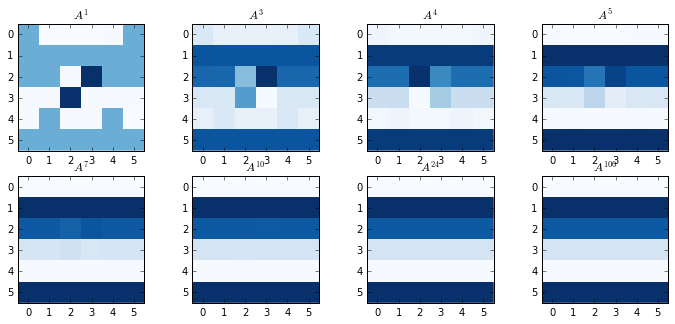

In [10]:
(f, axs) = plt.subplots(2,4,figsize=(12,5))

for inx, power in enumerate([1,3,4,5,7,10,24,100]):
    E = LA.matrix_power(A,power)
    im = axs[inx/4][inx%4].imshow(E, interpolation='none', cmap='Blues')
    axs[inx/4][inx%4].set_title('$A^{'+str(power)+'}$')  
plt.show()

__f) Independent Chains __

The function below is used to generate chains for a given transiton kernel _K_, initial state, number of chains _N_, and length of chain _M_ 

In [11]:
def generateChains(K, initState, N, M):
    # K is the transition kernel
    # N is the number of chains
    # M is the length of chain
    chains = np.zeros((N,M), dtype=np.int)
    chains[:,0] = initState-1 # -1, since index starts from 0
    for n in range(N):
        for m in range(1,M):
            chains[n][m] = np.random.choice(range(6), p=K[:,chains[n][m-1]])
    
    return (chains+1) # +1, since index starts from 0

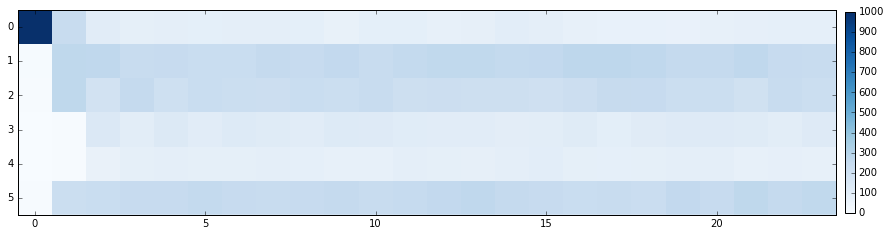

In [12]:
# Generate 1000 independent sequence of length Tmix with inital state '1'
chains = generateChains(A,1,1000,Tmix)

# Generate histograms
col = np.zeros(1000)
t = np.array([[j for j in np.histogram(chains[:,i], bins=range(1,8))[0][:]] for i in range(Tmix)])

# Plot the figure
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(t.T,interpolation='none', cmap='Blues')
fig.colorbar(im, fraction=0.012, pad=0.01)
plt.show()

__g) Dependent Samples__

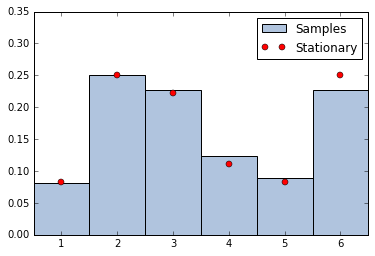

In [13]:
# Generate a chain of length 1000
chain = generateChains(A,1,1,1000)[0]

# Extract the histogram after discarding first Tmix terms
(counts, edges) = np.histogram(chain[Tmix::], bins=range(1,8),density=True)

# Plot the histogram and stationary distribution
xaxis = np.arange(1,7) + 0.5
p1 = plt.bar(range(1,7), counts, color='LightSteelBlue',width=1.0)
p2 = plt.plot(xaxis,u,'ro')
plt.xticks(xaxis, range(1,7))
plt.ylim([0, 0.35])
plt.legend((p1[0], p2[0]), ('Samples', 'Stationary'))
plt.show()

In [14]:
print "Stationary distribution"
print np.around(u,decimals=4)
print "Sample distribution"
print np.around(counts,decimals=4)

Stationary distribution
[ 0.0833  0.25    0.2222  0.1111  0.0833  0.25  ]
Sample distribution
[ 0.082   0.25    0.2275  0.124   0.0891  0.2275]
